# 따릉이 데이터를 활용한 데이터 분석
- 각 날짜의 1시간 전의 기상상황을 가지고 1시간 후의 따릉이 대여수를 예측해보세요. 

## 1. 라이브러리 및 데이터

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mglearn
import joblib
import math

from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from statsmodels.graphics.tsaplots import plot_acf, acf
from sklearn.linear_model import Ridge,Lasso,ElasticNet, LinearRegression, SGDRegressor, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC, SVR
from sklearn.compose import make_column_transformer,ColumnTransformer
import math
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics
from xgboost import XGBClassifier, XGBRFRegressor, XGBRegressor

matplotlib.rcParams['font.family']='Malgun Gothic'
plt.rcParams['font.size']=14
matplotlib.rcParams['axes.unicode_minus'] = False
import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv')
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


## 2. 탐색적 자료분석

### pd.DataFrame.head()
 - 데이터 프레임의 위에서 부터 n개 행을 보여주는 함수
 - n의 기본 값(default 값)은 5

In [3]:
display(train.head().T, test.head().T)

,0,1,2,3,4
id,3.000,6.000,7.000,8.00,9.000
hour,20.000,13.000,6.000,23.00,18.000
hour_bef_temperature,16.300,20.100,13.900,8.10,29.500
hour_bef_precipitation,1.000,0.000,0.000,0.00,0.000
hour_bef_windspeed,1.500,1.400,0.700,2.70,4.800
hour_bef_humidity,89.000,48.000,79.000,54.00,7.000
hour_bef_visibility,576.000,916.000,1382.000,946.00,2000.000
hour_bef_ozone,0.027,0.042,0.033,0.04,0.057
hour_bef_pm10,76.000,73.000,32.000,75.00,27.000
hour_bef_pm2.5,33.000,40.000,19.000,64.00,11.000


,0,1,2,3,4
id,0.000,1.000,2.00,4.000,5.000
hour,7.000,17.000,13.00,6.000,22.000
hour_bef_temperature,20.700,30.000,19.00,22.500,14.600
hour_bef_precipitation,0.000,0.000,1.00,0.000,1.000
hour_bef_windspeed,1.300,5.400,2.10,2.500,3.400
hour_bef_humidity,62.000,33.000,95.00,60.000,93.000
hour_bef_visibility,954.000,1590.000,193.00,1185.000,218.000
hour_bef_ozone,0.041,0.061,0.02,0.027,0.041
hour_bef_pm10,44.000,49.000,36.00,52.000,18.000
hour_bef_pm2.5,27.000,36.000,28.00,38.000,15.000


+ id : 날짜와 시간별 id
+ hour_bef_temperature : 1시간 전 기온
+ hour_bef_precipitation : 1시간 전 비 정보, 비가 오지 않았으면 0, 비가 오면 1
+ hour_bef_windspeed : 1시간 전 풍속(평균)
+ hour_bef_humidity : 1시간 전 습도
+ hour_bef_visibility : 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
+ hour_bef_ozone : 1시간 전 오존
+ hour_bef_pm10 : 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
+ hour_bef_pm2.5 : 1시간 전 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
+ count : 시간에 따른 따릉이 대여 수 

### pd.DataFrame.shape
 - 데이터 프레임의 행의 개수와 열의 개수가 저장되어 있는 속성(attribute)

In [4]:
print(train.shape)
print(test.shape)

(1459, 11)
(715, 10)


### pd.DataFrame.info()
- 데이터셋의 column별 정보를 알려주는 함수
- 비어 있지 않은 값은 (non-null)은 몇개인지?
- column의 type은 무엇인지?
 - type의 종류 : int(정수), float(실수), object(문자열), 등등 (date, ...)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


### pd.DataFrame.describe()
- 숫자형 (int, float) column들의 기술 통계량을 보여주는 함수

- 기술통계량이란?
 - 해당 column을 대표할 수 있는 통계값들을 의미
 
 
- 기술통계량 종류
 - count: 해당 column에서 비어 있지 않은 값의 개수
 - mean: 평균
 - std: 표준편차
 - min: 최솟값 (이상치 포함)
 - 25% (Q1): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 1/4번째 지점에 있는 값
 - 50% (Q2): 중앙값 (전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 2/4번째 지점에 있는 값)
 - 75% (Q3): 전체 데이터를 순서대로 정렬했을 때, 아래에서 부터 3/4번째 지점에 있는 값
 - max: 최댓값 (이상치 포함) 
 
 
 
- 이상치: 울타리 밖에 있는 부분을 이상치라고 정의함
   - 아래쪽 울타리: $Q_1$ - $1.5 * IQR$
   - 위쪽 울타리: $Q_3$ + $1.5 * IQR$
   - $IQR$ = $Q_3 - Q_1$
 
 
<img src="https://miro.medium.com/max/10125/1*NRlqiZGQdsIyAu0KzP7LaQ.png" width="700" height="500">

In [6]:
train.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


### pd.DataFrame.groupby()
 - 집단에 대한 통계량 확인 
 
<img src="https://s3.amazonaws.com/files.dezyre.com/images/Tutorials/Split+Apply+Combine+Strategy.png" width="700" height="500">

In [7]:
train.groupby(['hour']).count()

,id,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
hour,,,,,,,,,,
0,60,59,59,58,59,59,59,59,58,60
1,61,61,61,60,61,61,0,0,0,61
2,61,61,61,60,61,61,61,61,60,61
3,61,61,61,60,61,61,61,61,60,61
4,61,61,61,61,61,61,61,61,60,61
5,61,61,61,61,61,61,61,61,59,61
6,61,61,61,61,61,61,60,60,58,61
7,61,61,61,61,61,61,60,60,59,61
8,61,61,61,61,61,61,61,61,59,61


In [8]:
train.groupby(['hour']).mean()

,id,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
hour,,,,,,,,,,
0,1200.016667,14.788136,0.016949,1.965517,58.169492,1434.220339,0.033763,55.881356,30.982759,71.766667
1,1074.918033,14.155738,0.049180,1.836667,60.459016,1400.852459,NaN,NaN,NaN,47.606557
2,1077.885246,13.747541,0.049180,1.633333,61.721311,1374.278689,0.030492,58.475410,31.366667,31.409836
3,1146.704918,13.357377,0.032787,1.620000,63.131148,1326.311475,0.031213,59.180328,31.466667,21.377049
4,1194.786885,13.001639,0.016393,1.409836,64.573770,1264.606557,0.031984,58.278689,32.116667,13.524590
5,1091.819672,12.673770,0.016393,1.296721,66.000000,1203.426230,0.031623,56.721311,31.525424,13.114754
6,1112.393443,12.377049,0.016393,1.331148,67.409836,1146.229508,0.029317,56.150000,31.603448,24.557377
7,1086.262295,12.191803,0.016393,1.262295,67.934426,1150.311475,0.025300,56.533333,31.779661,62.360656
8,1086.491803,12.600000,0.032787,1.632787,64.049180,1152.868852,0.021197,57.918033,31.796610,136.688525


In [9]:
train.groupby(['hour'])['count'].mean()

hour
0      71.766667
1      47.606557
2      31.409836
3      21.377049
4      13.524590
5      13.114754
6      24.557377
7      62.360656
8     136.688525
9      93.540984
10     78.803279
11     88.327869
12    111.901639
13    120.050000
14    134.590164
15    152.967213
16    169.100000
17    187.133333
18    262.163934
19    201.606557
20    164.868852
21    168.816667
22    148.245902
23    103.852459
Name: count, dtype: float64

<AxesSubplot:xlabel='hour'>

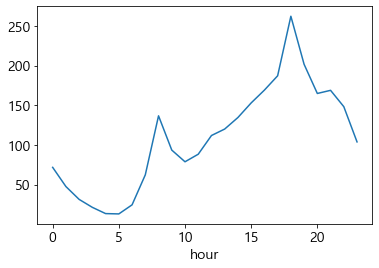

In [10]:
train.groupby(['hour']).mean()['count'].plot()

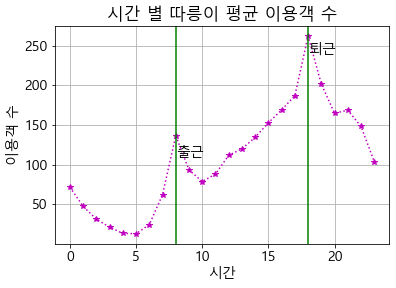

In [11]:
plt.plot(train.groupby(['hour']).mean()['count'], 'm*:')
plt.grid()
plt.title('시간 별 따릉이 평균 이용객 수')
plt.xlabel('시간')
plt.ylabel('이용객 수')

plt.axvline(8, color = 'g')
plt.axvline(18, color = 'g')

plt.text(8, 110, '출근')
plt.text(18, 240, '퇴근')
plt.show()

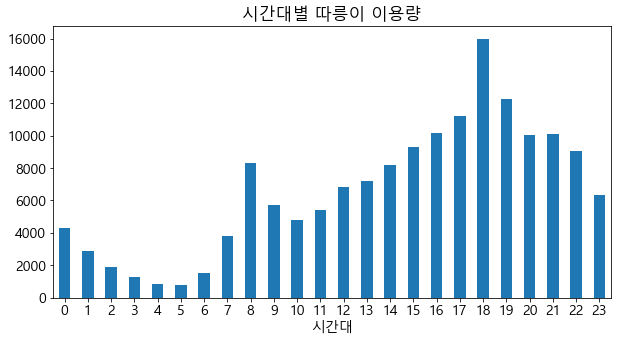

In [12]:
# 시간대별 이용량
plt.figure(figsize = (10,5))
plt.title('시간대별 따릉이 이용량')
train.groupby('hour')['count'].sum().plot.bar()
plt.xticks(rotation = 0)
plt.xlabel('시간대')
plt.show()

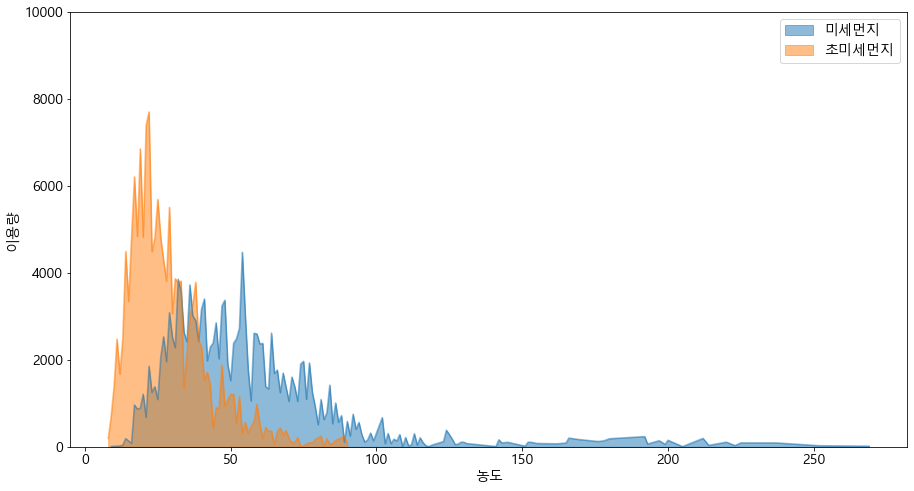

In [13]:
#미세먼지 농도별 이용량
plt.figure(figsize = (15,8))
train.groupby('hour_bef_pm10')['count'].sum().plot.area(label = '미세먼지',stacked=False)
train.groupby('hour_bef_pm2.5')['count'].sum().plot.area(label = '초미세먼지',stacked=False)
plt.xlabel('농도')
plt.ylabel('이용량')
plt.ylim(0,10000)
plt.legend()
plt.show()

- 미세먼지농도가 낮을 때 이용량이 많다.
- 그냥 높은 날이 별로 없어서일 가능성도 있음

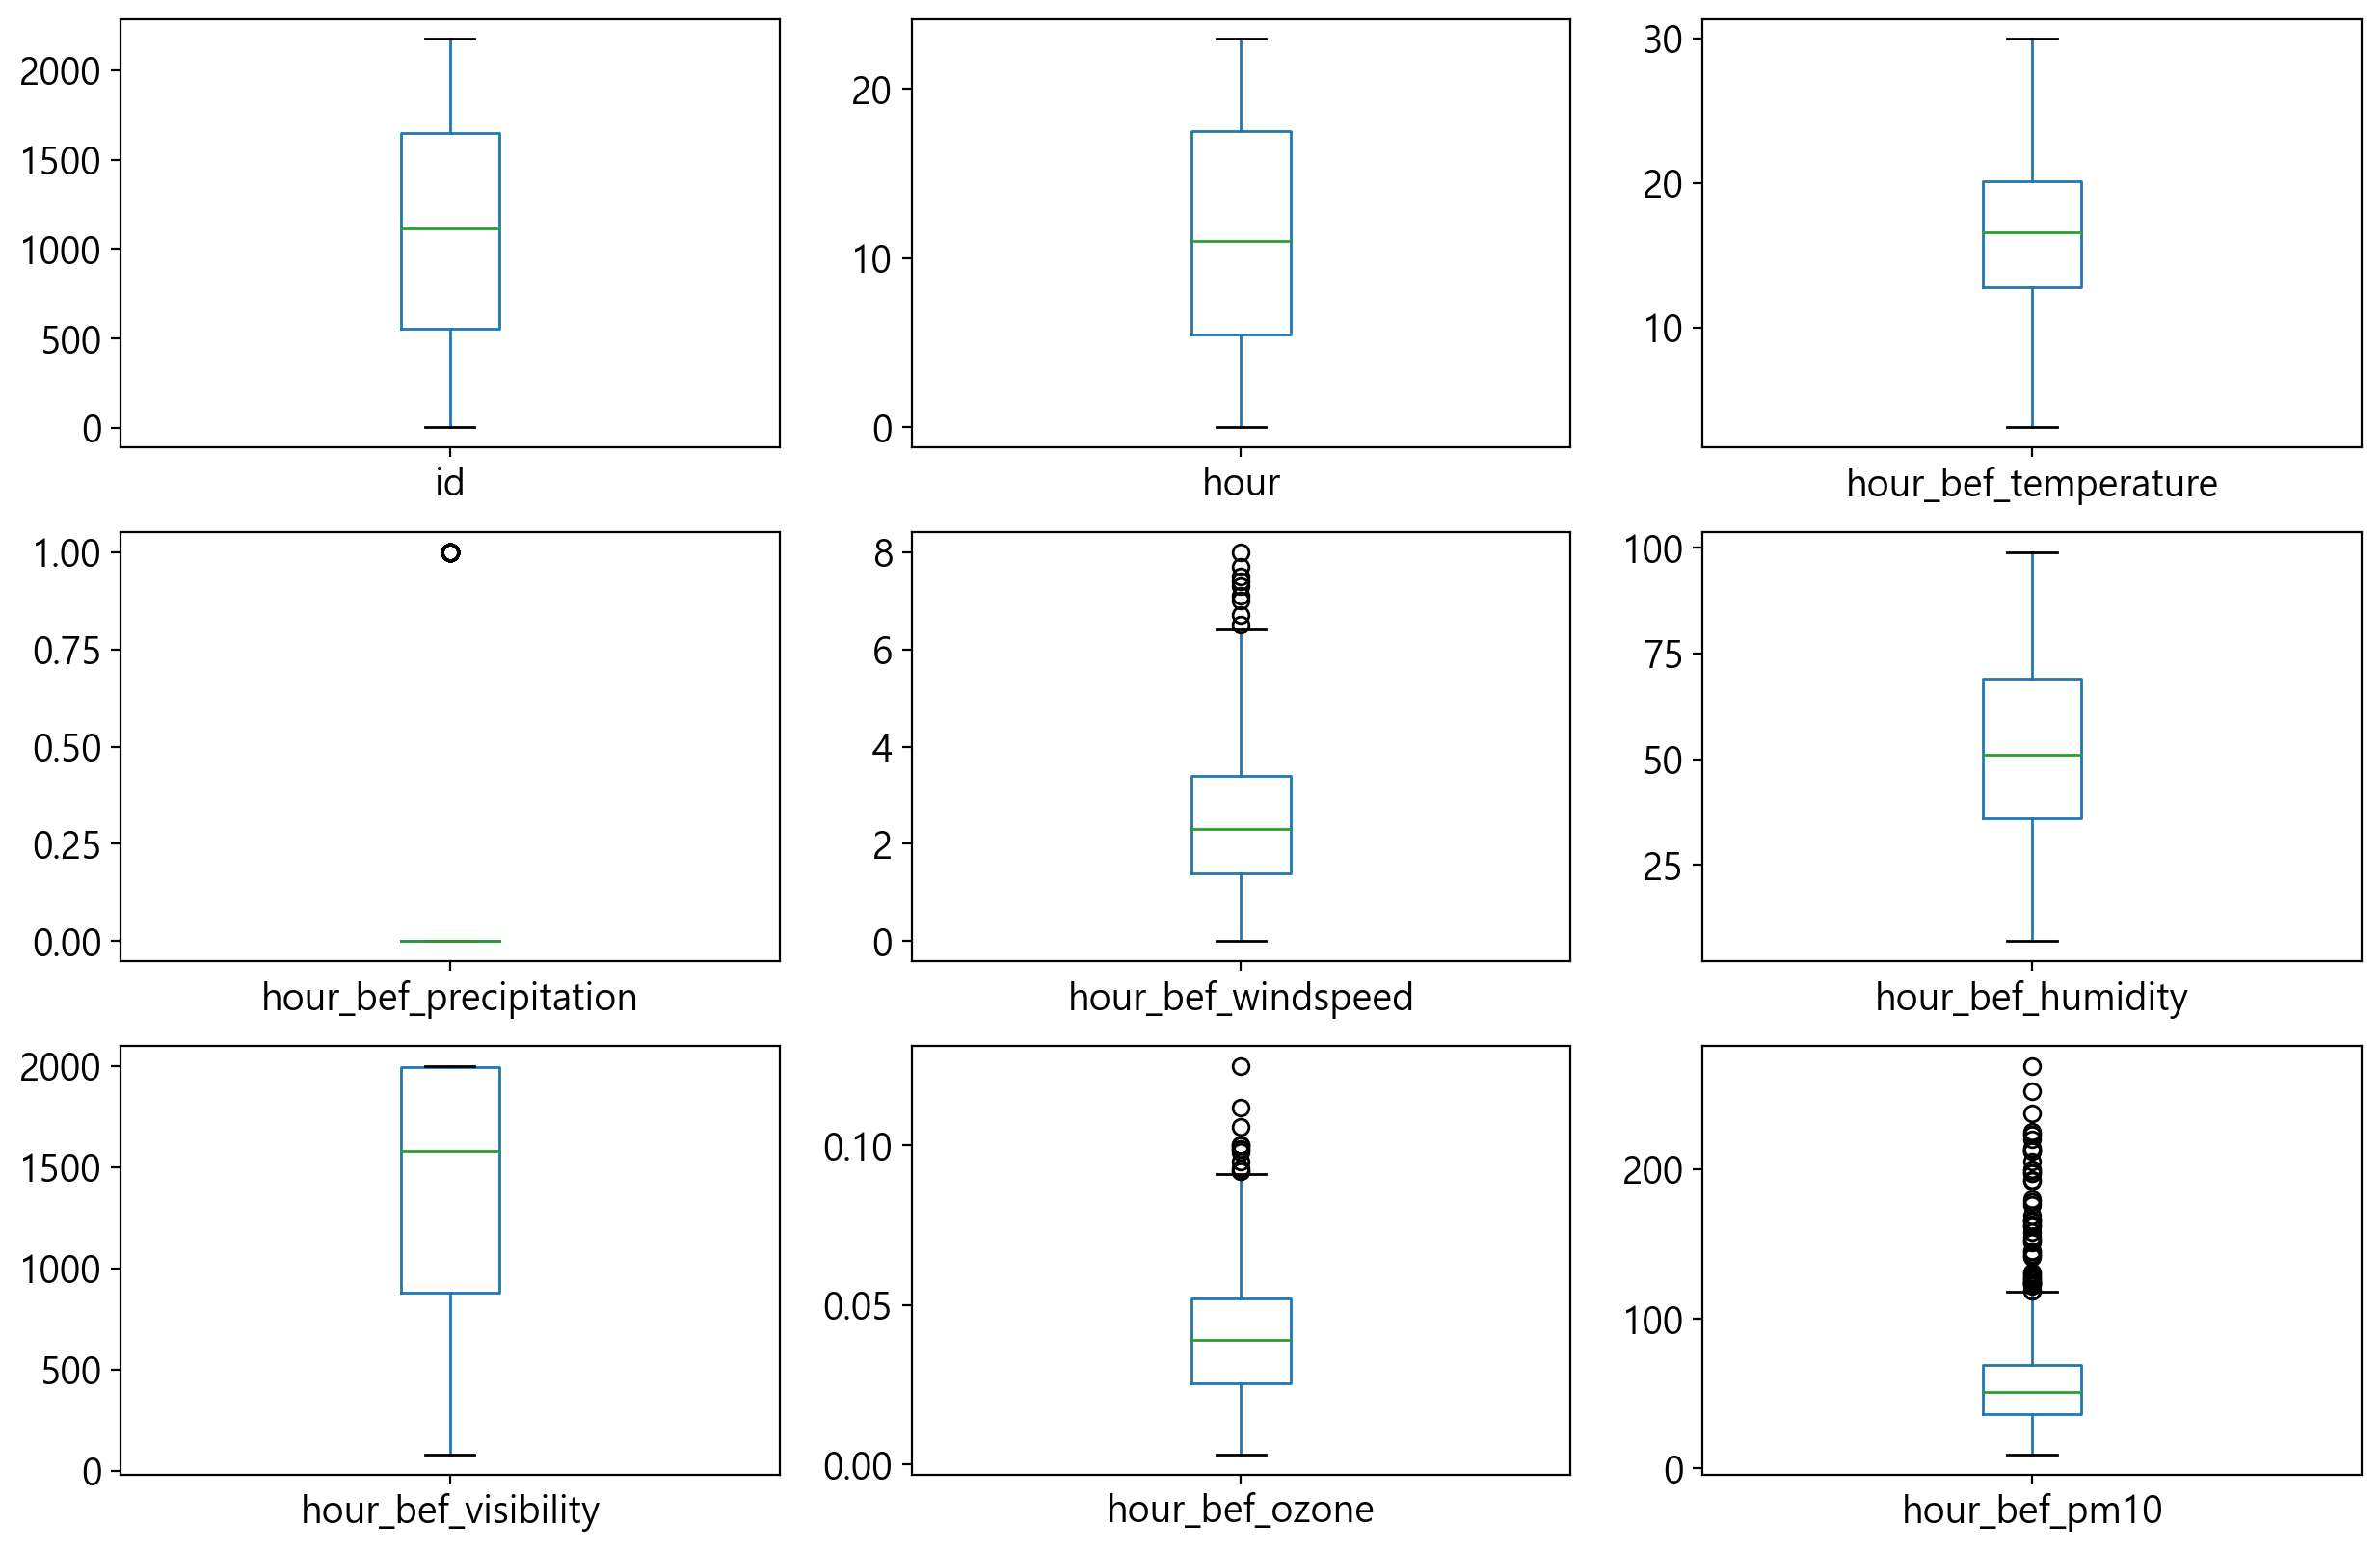

In [15]:
#박스 플롯 확인
fig, ax = plt.subplots(3,3,figsize = (15,10), dpi = 200)
for col,ax in zip(train.columns, ax.flatten()):
    train[col].plot.box(ax =ax)
plt.show()

## 3. 데이터 전처리

### pd.Series.isna()
- 결측치 여부를 확인해줍니다.
- 결측치면 True, 아니면 False

In [17]:
## 3. 데이터 전처리
## Data Cleansing & Pre-Processing  
# hour을 기준으로 그룹을 묶는다
a1 = train.groupby('hour')['hour_bef_temperature']
train['hour_bef_temperature'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_temperature']
test['hour_bef_temperature'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_precipitation
a1 = train.groupby('hour')['hour_bef_precipitation']
train['hour_bef_precipitation'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_precipitation']
test['hour_bef_precipitation'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_windspeed
a1 = train.groupby('hour')['hour_bef_windspeed']
train['hour_bef_windspeed'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_windspeed']
test['hour_bef_windspeed'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_humidity
a1 = train.groupby('hour')['hour_bef_humidity']
train['hour_bef_humidity'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_humidity']
test['hour_bef_humidity'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_visibility
a1 = train.groupby('hour')['hour_bef_visibility']
train['hour_bef_visibility'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_visibility']
test['hour_bef_visibility'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_ozone
a1 = train.groupby('hour')['hour_bef_ozone']
train['hour_bef_ozone'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_ozone']
test['hour_bef_ozone'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_pm10
a1 = train.groupby('hour')['hour_bef_pm10']
train['hour_bef_pm10'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_pm10']
test['hour_bef_pm10'] = b1.apply(lambda x : x.fillna(x.mean()))

# hour_bef_pm2.5
a1 = train.groupby('hour')['hour_bef_pm2.5']
train['hour_bef_pm2.5'] = a1.apply(lambda x : x.fillna(x.mean()))

b1 = test.groupby('hour')['hour_bef_pm2.5']
test['hour_bef_pm2.5'] = b1.apply(lambda x : x.fillna(x.mean()))

m0 = train[train['hour'] == 0]['hour_bef_ozone'].median()
m2 = train[train['hour'] == 2]['hour_bef_ozone'].median()
train['hour_bef_ozone'].fillna((m0 + m2) / 2, inplace = True)

m0 = test[test['hour'] == 0]['hour_bef_ozone'].median()
m2 = test[test['hour'] == 2]['hour_bef_ozone'].median()
test['hour_bef_ozone'].fillna((m0 + m2) / 2, inplace = True)

m0 = train[train['hour'] == 0]['hour_bef_pm10'].median()
m2 = train[train['hour'] == 2]['hour_bef_pm10'].median()
train['hour_bef_pm10'].fillna((m0 + m2) / 2, inplace = True)

m0 = test[test['hour'] == 0]['hour_bef_pm10'].median()
m2 = test[test['hour'] == 2]['hour_bef_pm10'].median()
test['hour_bef_pm10'].fillna((m0 + m2) / 2, inplace = True)

m0 = train[train['hour'] == 0]['hour_bef_pm2.5'].median()
m2 = train[train['hour'] == 2]['hour_bef_pm2.5'].median()
train['hour_bef_pm2.5'].fillna((m0 + m2) / 2, inplace = True)

m0 = test[test['hour'] == 0]['hour_bef_pm2.5'].median()
m2 = test[test['hour'] == 2]['hour_bef_pm2.5'].median()
test['hour_bef_pm2.5'].fillna((m0 + m2) / 2, inplace = True)

display(train.isna().sum())
display(test.isna().sum())

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64

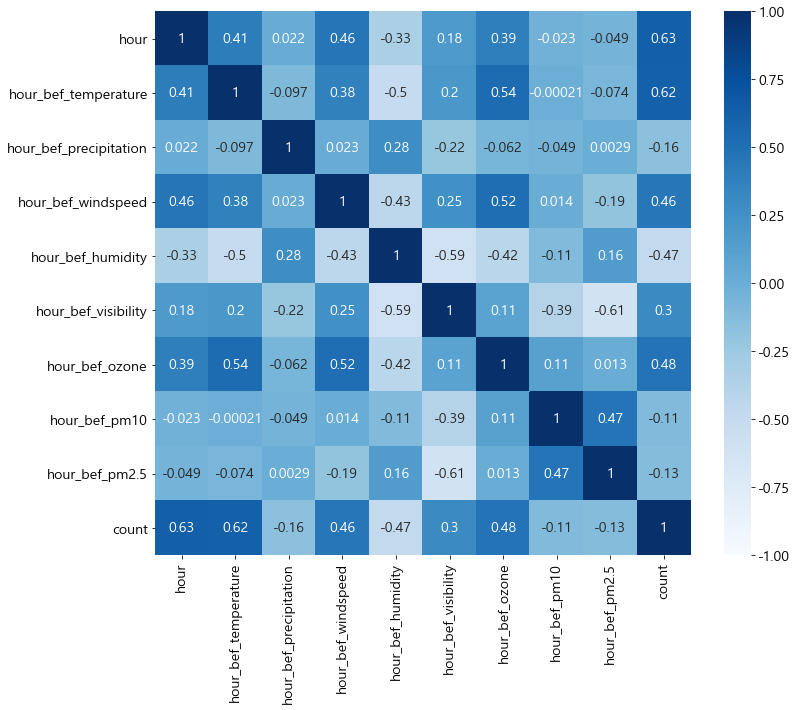

In [18]:
train_corr = train.drop('id', axis = 1)
plt.figure(figsize = (12, 10))
sns.heatmap(train_corr.corr(), cmap = 'Blues', annot = True, vmin = -1 ,vmax = 1)
plt.show()

- count와 상관이 있는 변수는 'hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_ozone' 정도로 보인다

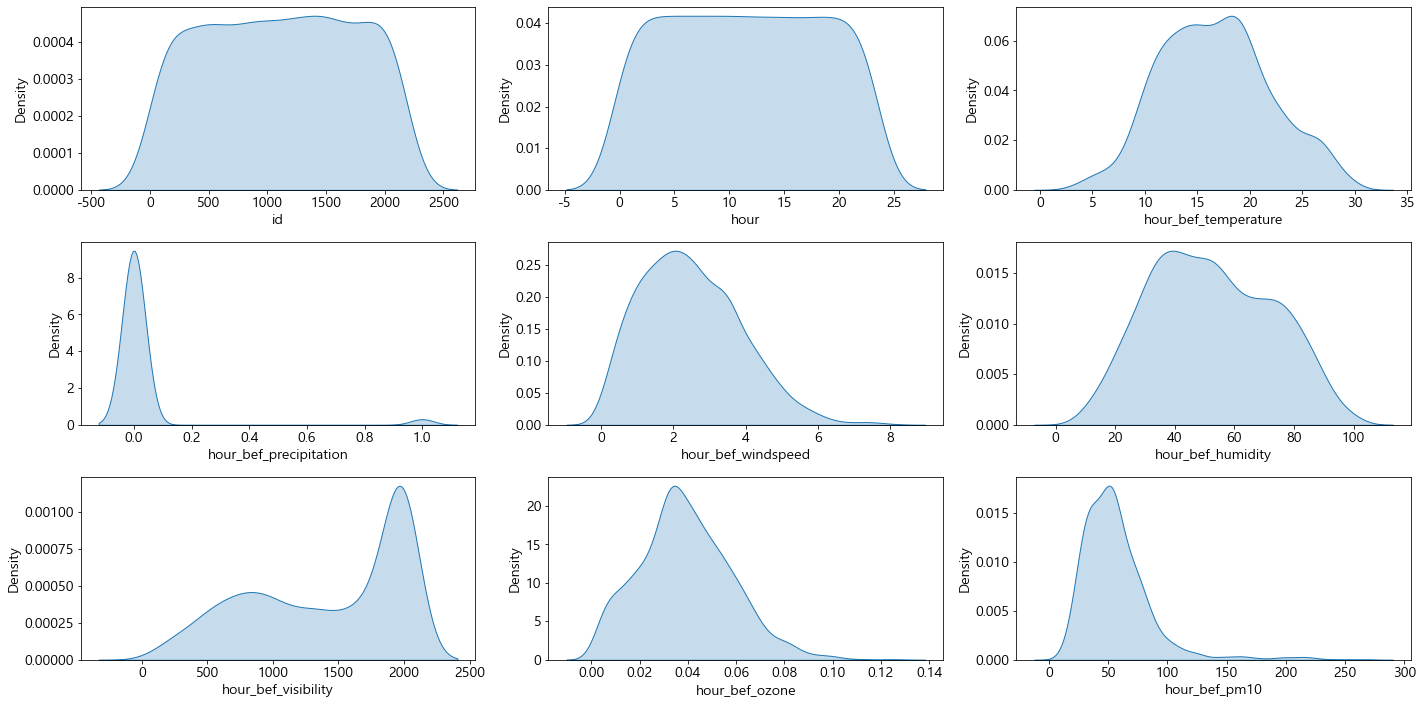

In [19]:
fig, ax = plt.subplots(3,3, figsize = (20,10))

for col , ax in zip(train.columns, ax.flatten()):
    sns.kdeplot(train[col],fill=True, ax = ax)

plt.tight_layout()
plt.show()

### 다중공선성 확인

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
train_vif = train.drop(['id', 'count'], axis = 1)
vif = pd.DataFrame()
vif['VIF Factor']= [ variance_inflation_factor(train_vif.values, i )  for i in range(train_vif.shape[1] ) ]
vif['features'] = train_vif.columns
vif

,VIF Factor,features
0,5.345316,hour
1,15.507558,hour_bef_temperature
2,1.173192,hour_bef_precipitation
3,7.039008,hour_bef_windspeed
4,5.543728,hour_bef_humidity
5,6.685721,hour_bef_visibility
6,9.112449,hour_bef_ozone
7,5.687797,hour_bef_pm10
8,8.277611,hour_bef_pm2.5


In [21]:
train_vif = train_vif.drop('hour_bef_temperature', axis = 1)
# test = test.drop('hour_bef_temperature', axis = 1)
vif = pd.DataFrame()
vif['VIF Factor']= [ variance_inflation_factor(train_vif.values, i )  for i in range(train_vif.shape[1] ) ]
vif['features'] = train_vif.columns
vif

,VIF Factor,features
0,5.091547,hour
1,1.173060,hour_bef_precipitation
2,7.007798,hour_bef_windspeed
3,5.451048,hour_bef_humidity
4,5.361779,hour_bef_visibility
5,7.529601,hour_bef_ozone
6,5.651012,hour_bef_pm10
7,7.985545,hour_bef_pm2.5


## 4. 변수 선택 및 모델 구축

In [22]:
target = train['count']
train_df = train.drop('count', axis = 1)
train_df

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0
...,...,...,...,...,...,...,...,...,...,...
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0


In [23]:
train_df = train[['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_precipitation', 'hour_bef_humidity']]
test_df = test[['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_precipitation', 'hour_bef_humidity']]
train_df

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_precipitation,hour_bef_humidity
0,20,16.3,1.5,1.0,89.0
1,13,20.1,1.4,0.0,48.0
2,6,13.9,0.7,0.0,79.0
3,23,8.1,2.7,0.0,54.0
4,18,29.5,4.8,0.0,7.0
...,...,...,...,...,...
1454,4,16.8,1.6,0.0,53.0
1455,3,10.8,3.8,0.0,45.0
1456,5,18.3,1.9,0.0,54.0
1457,21,20.7,3.7,0.0,37.0


### model.fit()
- 모델 학습

In [24]:
x_train, x_test, y_train, y_test = train_test_split(train_df, target, test_size = 0.2, random_state = 1)

In [25]:
model_ridge = make_pipeline(StandardScaler(), Ridge())
model_lasso = make_pipeline(StandardScaler(), Lasso())
model_lr = make_pipeline(StandardScaler(), LinearRegression())
model_logi = make_pipeline(StandardScaler(), LogisticRegression())
model_dt = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state = 1))
model_svm = make_pipeline(StandardScaler(), SVR())
model_bagg = make_pipeline(StandardScaler(), BaggingRegressor())
model_rf = make_pipeline(StandardScaler(), RandomForestRegressor())
model_xgb = make_pipeline(StandardScaler(), XGBRegressor())

In [26]:
model_vote = VotingRegressor(estimators = [('tree', model_dt), ('svm', model_svm), ('xgb', model_xgb), 
                                            ('lr', model_lr), ('bagg', model_bagg), ('rf', model_rf)])

In [27]:
model_dt.fit(x_train, y_train)
print('train dt rmse : ', metrics.mean_squared_error(y_train, model_dt.predict(x_train))**0.5)
print('test dt rmse : ', metrics.mean_squared_error(y_test, model_dt.predict(x_test))**0.5)
print()

model_lr.fit(x_train, y_train)
print('train lr rmse : ', metrics.mean_squared_error(y_train, model_lr.predict(x_train))**0.5)
print('test lr rmse : ', metrics.mean_squared_error(y_test, model_lr.predict(x_test))**0.5)
print()

model_xgb.fit(x_train, y_train)
print('train xgb rmse : ', metrics.mean_squared_error(y_train, model_xgb.predict(x_train))**0.5)
print('test xgb rmse : ', metrics.mean_squared_error(y_test, model_xgb.predict(x_test))**0.5)
print()

model_svm.fit(x_train, y_train)
print('train svm rmse : ', metrics.mean_squared_error(y_train, model_svm.predict(x_train))**0.5)
print('test svm rmse : ', metrics.mean_squared_error(y_test, model_svm.predict(x_test))**0.5)
print()

model_vote.fit(x_train, y_train)
print('train voting rmse : ', metrics.mean_squared_error(y_train, model_vote.predict(x_train))**0.5)
print('test voting rmse : ', metrics.mean_squared_error(y_test, model_vote.predict(x_test))**0.5)
print()

model_bagg.fit(x_train, y_train)
print('train bagging rmse : ', metrics.mean_squared_error(y_train, model_bagg.predict(x_train))**0.5)
print('test bagging rmse : ', metrics.mean_squared_error(y_test, model_bagg.predict(x_test))**0.5)
print()

model_rf.fit(x_train, y_train)
print('train voting rmse : ', metrics.mean_squared_error(y_train, model_rf.predict(x_train))**0.5)
print('test voting rmse : ', metrics.mean_squared_error(y_test, model_rf.predict(x_test))**0.5)
print()

train dt rmse :  0.0
test dt rmse :  59.66392751550423

train lr rmse :  52.98403507172296
test lr rmse :  54.87739095350218

train xgb rmse :  6.707013666180027
test xgb rmse :  46.18506788442133

train svm rmse :  57.977488844705896
test svm rmse :  59.37990992463538

train voting rmse :  22.16173353658883
test voting rmse :  43.89555178306078

train bagging rmse :  17.323095074635685
test bagging rmse :  45.21292206789789

train voting rmse :  15.548086368335612
test voting rmse :  44.737928895393836



### xgboost parameter tuning

□ General Parameters : XGBoost의 전반적인 기능을 정의함.
 > booster [default=gbtree] >> 일반적으로 gbtree의 성능이 낫다.
   - gbtree: tree-based models
   - gblinear: linear models
   
   
 > silent [default=0]
   - 1: 동작 메시지를 프린트하지 않음.

□ Booster Parameters (아래는 gbtree booster 기준으로 정리되어있음.)
 > eta [default=0.3] => learning_rate
   - GBM의 학습 속도와 유사.
   - 각 단계에서 가중치를 줄임으로써 모델을 더 강건하게 만든다.
   - 일반적으로 0.01-0.2
   
   
 > min_child_weight [default=1] (Should be tuned using CV)
   - child의 관측(?)에서 요구되는 최소 가중치의 합
   - over-fitting vs under-fitting을 조정하기 위한 파라미터.
   - 너무 큰 값이 주어지면 under-fitting.
   
   
 > max_depth [default=6] (Should be tuned using CV)
   - 트리의 최대 깊이.
   - 일반적으로 3-10
   
   
 > max_leaf_nodes
   - 최종 노드의 최대 개수. (max number of terminal nodes)
   - 이진 트리가 생성되기 때문에 max_depth가 6이면 max_leaf_nodes는 2^6개가 됨.
   
   
 > gamma [default=0]
   - 분할을 수행하는데 필요한 최소 손실 감소를 지정한다.
   - 알고리즘을 보수적으로 만든다. loss function에 따라 조정해야 한다.
   
   
 > subsample [default=1]
   - 각 트리마다의 관측 데이터 샘플링 비율.
   - 값을 적게 주면 over-fitting을 방지하지만 값을 너무 작게 주면 under-fitting.
   - 일반적으로 0.5-1
   
   
 > colsample_bytree [default=1]
   - 각 트리마다의 feature 샘플링 비율.
   - 일반적으로 0.5-1
   
   
 > lambda [default=1] => reg_lambda
   - 가중치에 대한 L2 정규화 용어 (Ridge 회귀 분석과 유사(?))
   
   
 > alpha [default=0] => reg_alpha
   - 가중치에 대한 L1 정규화 용어 (Lasso 회귀 분석과 유사(?))
   
   
 > scale_pos_weight [default=1]
   - 불균형한 경우 더 빠른 수렴(convergence)에 도움되므로 0보다 큰 값을 쓸것.

In [ ]:
# grid search
model_xgb = Pipeline( [ ('scl', StandardScaler()), ('xgb', XGBRegressor(n_jobs = 12)) ] )
param_value = {'xgb__n_estimators' : [50, 100, 150, 200, 250, 300],
               'xgb__learning_rate' : [0.01, 0.05, 0.1, 0.5, 1],
               'xgb__max_depth' : list(range(2, 20, 3)),
               'xgb__subsample' : [0.25, 0.5, 0.75, 1],
               'xgb__min_child_weight' : [0.5, 1, 1.5, 2]
              }
gridSearch = GridSearchCV(model_xgb, param_grid = param_value, cv = 5, n_jobs = 12, verbose = 1)
gridSearch.fit(x_train, y_train)

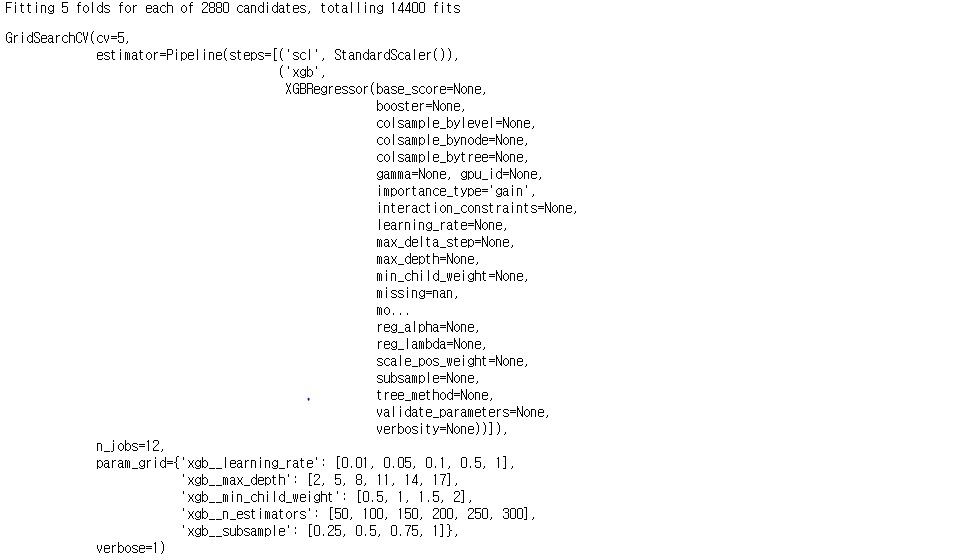
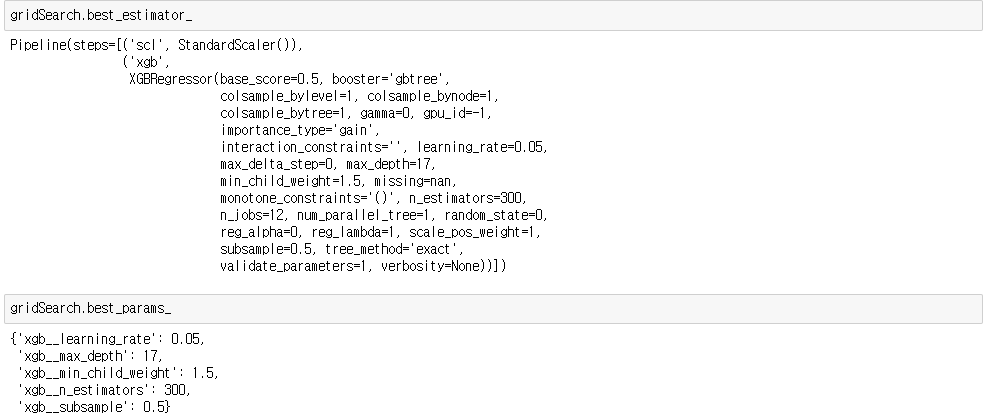

### model.predict()
- 모델 예측

In [ ]:
model_xgb = Pipeline( [ ('scl', StandardScaler()), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=17, min_child_weight=1.5,
                              monotone_constraints='()',
                              n_estimators=300, n_jobs=12, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None)) ] )
model_xgb.fit(train_df, target)

In [ ]:
submission['count'] = model_xgb.predict(test_df)
submission

In [ ]:
submission.to_csv('5조_예측.csv', index = False)